In [8]:
# %load model.py
import csv
import cv2
import random as rnd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import Flatten, Dense, Convolution2D, MaxPooling2D, Lambda, Cropping2D, Dropout
from keras.optimizers import Adagrad
from keras.utils import plot_model

def read_csv(root_path):
    with open(root_path + 'driving_log.csv', 'r') as f:
        reader = csv.reader(f)
        for line in reader:
            yield line

def make_local_path(path, local_root):
    basename = path.split('/')[-1]
    return local_root + 'IMG/' + basename

def read_data(data_path):
    samples = []
    for line in read_csv(data_path):
        images = [make_local_path(p, data_path) for p in line[0:3]]
        steering_angle = float(line[3])
        samples.append((images, steering_angle))
                
    return samples

def augment_with_side_cameras(angle_aug):
    """Returns a callable that can be passed to make_sample_array. 
    The callable will produce 3 samples for each log entry, augmenting 
    the steering angles for side camera images with the value passed in 
    angle_aug argument"""
    
    def transform(images, base_angle):
        center, left, right = images
        return [(center, base_angle),
                (left, base_angle + angle_aug),
                (right, base_angle - angle_aug)]
    
    return transform

def no_augmentation():
    """Returns a callable that can be passed to make_sample_array() as a transformer_fn. 
    The callable will return a single sample for center camera only.
    """
    
    def transform(images, angle):
        center = images[0]
        return [(center, angle)]
    
    return transform 

def make_sample_array(log_data, transformer_fn):
    """Create the sample array from the driving log data. 
    The parameter transformer_fn specifies the function that transforms each log entry
    into the list of tuples (filename, angle)"""
    
    result = []
    for images, angle in log_data:
        result += transformer_fn(images, angle)
    return result

def read_image(path):
    "Reads the image from a file and converts it to RGB color space"
    
    img = cv2.imread(path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def generator(samples, batch_size=32):
    "This generator iterates over a sample array, yielding batches of the given size."
    
    num_samples = len(samples)
    batch_size = batch_size
    while True: 
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for img_path, angle in batch_samples:
                img = read_image(img_path)
                images.append(img)
                angles.append(angle)

            X_train = np.array(images)
            y_train = np.array(angles)
            yield shuffle(X_train, y_train)
            
def balance_samples(samples):
    """
    This function drops a portion of samples that have steering angles close to zero,
    in order to balance the dataset towards non-zero values.
    """
    zero_threshold = 0.1
    def should_keep_sample(sample):
        angle = sample[1]
        keep_prob = rnd.uniform(0, 1)
        return (abs(angle) > zero_threshold) or (keep_prob > 0.7) 

    return [s for s in samples if should_keep_sample(s)]
            

data_path = './driving-training/'
test_data_path = './driving-test/'

samples = balance_samples(read_data(data_path))
print("Dataset size: %d" % len(samples))


angle_correction = 0.2
train_samples, valid_samples = train_test_split(samples, test_size=0.2)
train_samples = make_sample_array(samples, augment_with_side_cameras(angle_correction))
valid_samples = make_sample_array(valid_samples, no_augmentation())

print("Training set size: %d" % len(train_samples))
print("Validation set size: %d" % len(valid_samples))

test_samples = read_data(test_data_path)
test_samples = make_sample_array(test_samples, no_augmentation())

image_shape = (160, 320, 3)
cropping = ((60, 0), (0, 0))
batch_size = 128

model = Sequential()
model.add(Lambda(lambda x: (x - 127.0) / 127.0, input_shape=image_shape))
model.add(Cropping2D(cropping=cropping))
model.add(Convolution2D(24, kernel_size=(5, 5), strides=(2, 2), padding='valid', activation='relu'))
model.add(Convolution2D(36, kernel_size=(5, 5), strides=(2, 2), padding='valid', activation='relu'))
model.add(Convolution2D(48, kernel_size=(5, 5), strides=(2, 2), padding='valid', activation='relu'))
model.add(Convolution2D(64, kernel_size=(3, 3), padding='valid', activation='relu'))
model.add(Convolution2D(64, kernel_size=(3, 3), padding='valid', activation='relu'))

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

# plot_model(model, to_file="./output/model.png", show_layer_names=False, show_shapes=True)

optimizer = Adagrad(lr=0.001)
model.compile(loss='mse', optimizer=optimizer)

history = model.fit_generator(generator(train_samples, batch_size), len(train_samples) // batch_size, 
                             validation_data=generator(valid_samples, batch_size), 
                             validation_steps=(len(valid_samples) // batch_size), 
                             epochs = 10, 
                             verbose = 1)

test_error  = model.evaluate_generator(generator(test_samples), 
                                       steps=len(test_samples) // batch_size)
print("Model error on the test dataset: %.3f" % test_error)

model.save('model.h5')
print("Model has been saved")

Dataset size: 12392
Training set size: 37176
Validation set size: 2479
Epoch 1/10
290/290 [==============================] - 59s - loss: 0.2219 - val_loss: 0.1890

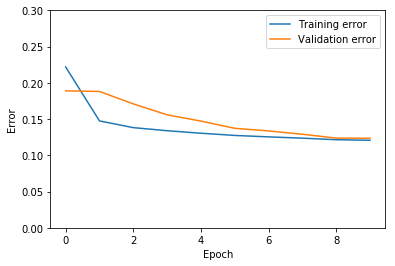

In [9]:
%matplotlib inline
epochs = history.epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, label='Training error')
plt.plot(epochs, val_loss, label='Validation error')
plt.ylim(0, 0.3)
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.savefig('./output/loss.png')

In [ ]:
from keras.utils import plot_model
plot_model(model, 'model.png')